<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/VQE_Qiskit_nature_AerSim_mkbahk_20250717.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit-nature qiskit-aer qiskit-algorithms qiskit==1.1.0 pyscf matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 10.2 MB/s eta 0:00:00


In [2]:
# prompt: Python에서 각종 warning 메세지를 출력하지 않는 코드를 작성해 주세요.
import warnings
warnings.filterwarnings('ignore')

In [3]:
### 물 분자(H₂O) VQE 계산 예제 코드

# 1. 필요한 라이브러리 임포트
import numpy as np
import matplotlib.pyplot as plt

# Qiskit 관련 임포트
from qiskit.primitives import BaseSamplerV2 as BaseSampler, BaseEstimatorV2 as BaseEstimator
from qiskit_aer.primitives import Estimator as AerEstimator


from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.drivers.pyscfd.pyscfdriver import PySCFDriver

from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit_algorithms.minimum_eigensolvers import VQE

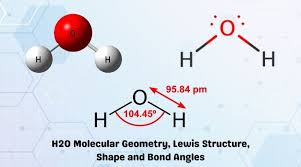

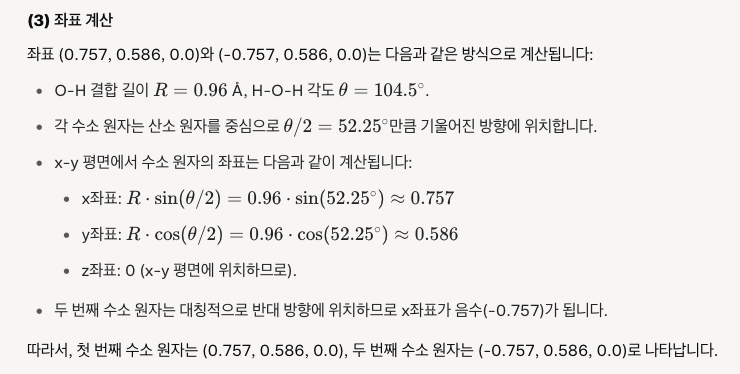

In [4]:
# 2. 물 분자 구조 정의
# PySCFDriver(양자화학계산용 라이브러리)를 사용하여 물 분자의 구조를 정의합니다.
# 분자 구조는 '원자 기호 x좌표 y좌표 z좌표' 형식의 문자열로 지정합니다.
# 단위는 옹스트롬(Angstrom)입니다.
h2o_geometry = "O 0.0 0.0 0.0; H 0.757 0.586 0.0; H -0.757 0.586 0.0"

In [5]:
# PySCFDriver 인스턴스 생성
# basis는 분자 오비탈을 표현하기 위한 기저 함수 집합입니다. 'sto-3g'는 계산량이 적어 예제에 적합합니다.
driver = PySCFDriver(atom=h2o_geometry, basis="sto-3g")
problem = driver.run()

In [6]:
# 3. 페르미온 해밀토니안을 큐비트 해밀토니안으로 변환
# 분자의 전자 구조 문제(페르미온)를 양자 컴퓨터가 다룰 수 있는 큐비트 문제로 변환합니다. 페르미온 해밀토니안(Fermionic Hamiltonian) -> 큐비트 해밀토니안(Qubit Hamiltonian)
# ParityMapper는 JordanWignerMapper보다 필요한 큐비트 수를 줄여줄 수 있습니다.
mapper = ParityMapper(num_particles=problem.num_particles) ##num_particles는 계산 대상 분자(여기서는 물 분자)의 전자 수
qubit_hamiltonian = mapper.map(problem.hamiltonian.second_q_op())

In [7]:
# 4. Ansatz (시험 파동 함수) 및 초기 상태 준비
# UCCSD Ansatz는 양자 화학에서 널리 사용되는 화학적으로 영감을 받은 Ansatz입니다.
# 초기 상태는 Hartree-Fock 상태로 설정합니다.
num_spatial_orbitals = problem.num_spatial_orbitals
## 물 분자(H₂O)에 STO-3G 기저 집합을 사용하면:
## 산소(O): 5개 공간 궤적 (1s, 2s, 2p_x, 2p_y, 2p_z).
## 수소(H): 각 1개 공간 궤적 (1s) × 2 = 2개.
## 총: $5 + 2 = 7$개의 공간 궤적.

num_particles = problem.num_particles
## 분자의 전자 수를 나타냅니다. 물 분자의 경우:
## 산소: 8개 전자.
## 수소: 1개 전자 × 2 = 2개 전자.
## 총: $8 + 2 = 10$개 전자.

num_particles는 (alpha 전자 수, beta 전자 수) 쌍으로 표현될 수 있으며, 물 분자는 스핀이 닫힌 시스템(closed-shell)이므로 (5, 5)로 설정됩니다.

initial_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
'''
Hartree-Fock 상태는 가장 낮은 에너지의 궤적을 전자로 채운 상태입니다.
예: 물 분자에서 STO-3G 기저 집합을 사용하면, 7개 공간 궤적(14개 스핀 궤적) 중 가장 낮은 5개 공간 궤적(10개 스핀 궤적)을 alpha 및 beta 전자로 채웁니다.
ParityMapper를 사용하므로, 이 상태는 큐비트로 표현되며, 일반적으로 $|11111...0\rangle$ 형태의 상태 벡터로 초기화됩니다(정확한 큐비트 수는 매핑에 따라 달라짐).

역할: HF 상태는 VQE에서 좋은 초기 추정치를 제공하여 Ansatz의 최적화 과정을 효율적으로 만듭니다.
'''

ansatz = UCCSD(num_spatial_orbitals, num_particles, mapper, initial_state=initial_state) # Using alternative initialization

In [8]:
# 5. 백엔드(시뮬레이터) 설정
# Qiskit Aer의 Estimator를 사용하여 해밀토니안의 기댓값을 효율적으로 계산합니다.
# shot-noise 효과를 제거하기 위해 shots=None으로 설정합니다 (이상적인 시뮬레이션).
aer_estimator = AerEstimator(run_options={"shots": None, "seed": 170}, transpile_options={"seed_transpiler": 170})

출력: vqe_result는 VQE 계산의 결과를 포함하는 객체로, 다음과 같은 정보를 제공합니다:<br>
* eigenvalue: 계산된 바닥 상태 에너지(최소 고유값).<br>
* optimal_parameters: 최적화된 Ansatz 파라미터.<br>
* optimal_value: 최종 에너지 값(동일한 eigenvalue).<br>
* cost_function_evals: 최적화 과정에서 수행된 함수 평가 횟수.<br>
* 기타 메타데이터(예: 최적화 횟수, 성공 여부 등).<br>

In [9]:
# 6. VQE 알고리즘 설정 및 실행
# 고전적인 최적화기(Optimizer)를 선택합니다. COBYLA는 간단하고 널리 사용되는 최적화기입니다.
optimizer = COBYLA(maxiter=100)

# 반복마다 비용(에너지)을 저장하기 위한 콜백 함수
cost_history = []
def store_intermediate_result(eval_count, parameters, mean, std):
    cost_history.append(mean)
    print(f"Iters. done: {eval_count} [Current cost: {mean}]")

# VQE 알고리즘 인스턴스 생성
vqe_solver = VQE(
    estimator=aer_estimator,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=store_intermediate_result
)

# VQE 계산 실행
vqe_result = vqe_solver.compute_minimum_eigenvalue(qubit_hamiltonian)

Iters. done: 1 [Current cost: -67.79643625376126]
Iters. done: 2 [Current cost: -72.26204666758386]
Iters. done: 3 [Current cost: -75.52833761324308]
Iters. done: 4 [Current cost: -74.77020256047541]
Iters. done: 5 [Current cost: -76.48935401282141]
Iters. done: 6 [Current cost: -75.46171904025034]
Iters. done: 7 [Current cost: -76.748297570046]
Iters. done: 8 [Current cost: -76.82616241780622]
Iters. done: 9 [Current cost: -76.62738635806181]
Iters. done: 10 [Current cost: -77.24827603782113]
Iters. done: 11 [Current cost: -76.00193910568582]
Iters. done: 12 [Current cost: -75.90705484940572]
Iters. done: 13 [Current cost: -76.4138837345625]
Iters. done: 14 [Current cost: -77.44838301406485]
Iters. done: 15 [Current cost: -76.07574098340734]
Iters. done: 16 [Current cost: -77.04895454035503]
Iters. done: 17 [Current cost: -76.97389093907753]
Iters. done: 18 [Current cost: -77.67117993171887]
Iters. done: 19 [Current cost: -76.54295875742216]
Iters. done: 20 [Current cost: -77.60200776


--- VQE 계산 결과 ---
최종 계산된 바닥 상태 에너지: -79.718146941194
정확한 바닥 상태 에너지 (고전 계산): -75.012437432494
--------------------


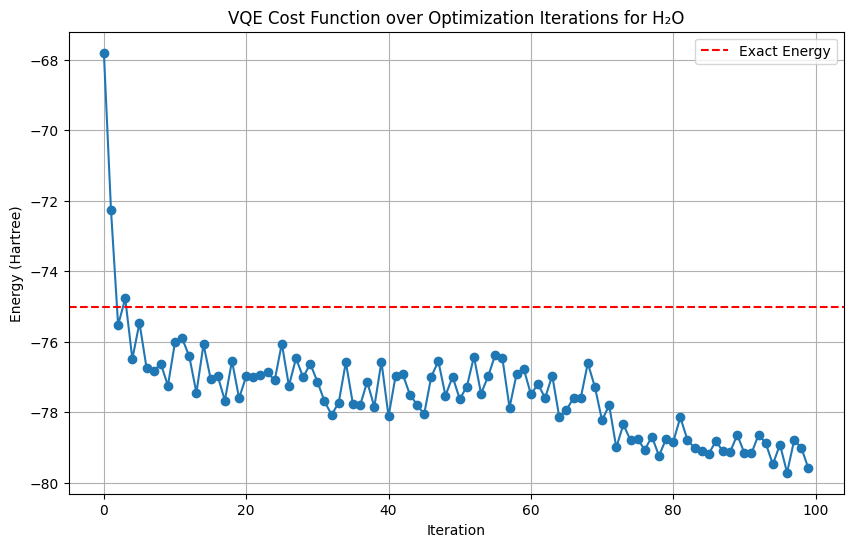

In [11]:
# 7. 결과 출력 및 시각화
print("\n--- VQE 계산 결과 ---")
print(f"최종 계산된 바닥 상태 에너지: {vqe_result.eigenvalue.real:.12f}")

# 정확한 바닥 상태 에너지 값 계산 (고전적인 방법)
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

# Instantiate NumPyMinimumEigensolver as the classical solver
classical_solver = NumPyMinimumEigensolver()

solver = GroundStateEigensolver(mapper, classical_solver)
exact_result = solver.solve(problem)
print(f"정확한 바닥 상태 에너지 (고전 계산): {exact_result.total_energies[0]:.12f}")
print("--------------------")

# 최적화 과정 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(len(cost_history)), cost_history, marker='o')
plt.axhline(y=exact_result.total_energies[0], color='r', linestyle='--', label='Exact Energy')
plt.title("VQE Cost Function over Optimization Iterations for H₂O")
plt.xlabel("Iteration")
plt.ylabel("Energy (Hartree)")
plt.legend()
plt.grid(True)
plt.show()